# The Linear Regression Model of Time Series
- An first attempt of Auto Regressive Model

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import data
df = pd.read_csv("JointData.csv", index_col = False)
# df.set_index(pd.DatetimeIndex(df["date"]), inplace=True)  # make index with date
df = df[["date","cases"]]  # use only daily increment of cases to forcast
df.reset_index(drop=True, inplace=True)
df.head()

,date,cases
0,2020-07-27,207.0
1,2020-07-28,128.0
2,2020-07-29,126.0
3,2020-07-30,105.0
4,2020-07-31,112.0


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    583 non-null    object 
 1   cases   583 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.2+ KB
None


## Autoregressive Model
- Use only past cases
- Remove day of week effect by replace $y_t$ with an average of 7 previous days(inclusive)
    - Each value is an average of data from all 7 different weekdays, thud day of week effect removed

In [5]:
# create a time series of cases, each value is an average of 7 previous days(include the current date)
# starting from the 7th day:
cases_ave = []
for i in range(6,len(df)):
    # remove day of week effect
    temp = np.mean(df.cases.iloc[i-6:i+1])  # 6 previous days and the exact date, 7 days' average
    cases_ave.append(temp)

df = df.iloc[6:].reset_index(drop = True)  # start on day 7, update index
df['case'] = cases_ave

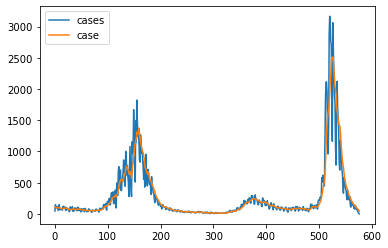

In [6]:
df.plot()
plt.show()  # cases- original data, case- smoothed version w/o day of week effect

In [7]:
df.head()

,date,cases,case
0,2020-08-02,46.0,114.142857
1,2020-08-03,147.0,105.571429
2,2020-08-04,91.0,100.285714
3,2020-08-05,114.0,98.571429
4,2020-08-06,116.0,100.142857


In [8]:
# work with time series:
df1 = df[["date", "case"]]
# df1["date"] = pd.to_datetime(df1["date"])  # convert to datatime
df1.set_index("date", inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 577 entries, 2020-08-02 to 2022-03-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   case    577 non-null    float64
dtypes: float64(1)
memory usage: 9.0+ KB


In [9]:
df1 = df1.to_dict()['case']  # convert to dict in order to convert to series

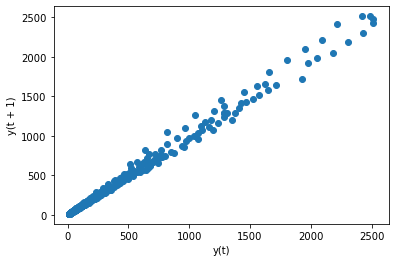

In [10]:
# check the lag
s = pd.Series(df1)
pd.plotting.lag_plot(s, lag = 1)  # larger lag --> weaker correlation
plt.show()

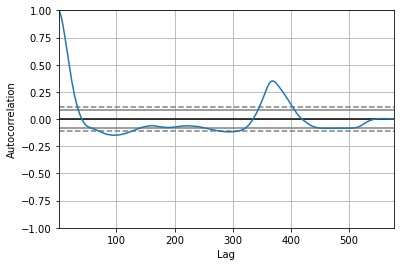

In [11]:
# autocorrelation plot
pd.plotting.autocorrelation_plot(s)
plt.show()

## Training Model

### AutoRegression
- assume observations from previous time steps are useful to predict values at latter time steps
    - true for Time Series
- choose a proper lag
    - use lag as variable
    - if all lag variables show no correlation with output, then the time series problem could be not predictable
    - from the visuals above, smaller lag yields better result, thus we use lag = 1

In [12]:
from statsmodels.tsa.ar_model import AutoReg
test_size = 7
train_size = 21
X = s.values
train, test = X[-(test_size+train_size):-test_size], X[-test_size:]
model = AutoReg(train, lags=1)
model = model.fit()
print('Coefficients: {}'.format(model.params))

Coefficients: [0.32252986 0.92614211]


In [13]:
# make predictions
pred = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
rmse = np.sqrt(mean_squared_error(test, pred))
r2 = r2_score(test, pred)
print("Test RMSE: {}".format(rmse))
# print("Coefficient of Determination: ", r2) -6.138002779278622?

Test RMSE: 14.679491575865361


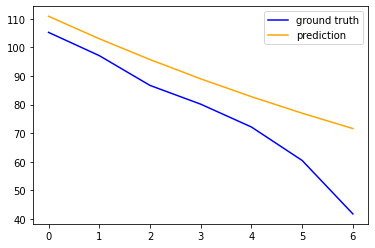

In [14]:
plt.plot(test, color = 'blue', label = "ground truth")
plt.plot(pred, color = 'orange', label = "prediction")
plt.legend()
plt.show()

In [15]:
train, test = X[-(test_size+train_size*3):-test_size], X[-test_size:]
model = AutoReg(train, lags=1)
model = model.fit()
print('Coefficients: {}'.format(model.params))
# make predictions
pred = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
rmse = np.sqrt(mean_squared_error(test, pred))
print("Test RMSE: {}".format(rmse))

Coefficients: [-2.74982508  0.99851909]
Test RMSE: 33.399094273122714


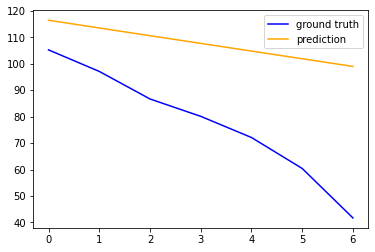

In [16]:
plt.plot(test, color = 'blue', label = "ground truth")
plt.plot(pred, color = 'orange', label = "prediction")
plt.legend()
plt.show()

Notice: absence of a periodic trend. As a result, more data does not always give us a better result
- from the plot of y vs t, if we use the 100 days before 7 last day(test) as training data, the model will yield a flat line.

In [26]:
# increase lag to have more complicated results
# example, lag = 3
train, test = X[-(test_size+train_size):-test_size], X[-test_size:]
model = AutoReg(train, lags=3)
model = model.fit()
print('Coefficients: {}'.format(model.params))
# make predictions
pred = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
rmse = np.sqrt(mean_squared_error(test, pred))
print("Test RMSE: {}".format(rmse))

Coefficients: [-1.77304776  1.18639808 -0.79034802  0.51760991]
Test RMSE: 12.204851341131434


In [27]:
train

(21,)

In [18]:
Lag = range(1,10)
rmse = []
for lag in Lag:  # check the model performance as lag increases
    model_d = AutoReg(train, lags = lag)
    model_d = model_d.fit()
    pred = model_d.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
    rmse.append(np.sqrt(mean_squared_error(test, pred)))

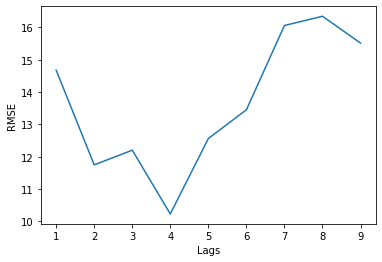

In [19]:
plt.plot(Lag, rmse)
plt.xlabel("Lags")
plt.ylabel("RMSE")
plt.show()

lag = 4 yields the best RMSE

In [20]:
# check the model at lag = 4
model_b21 = AutoReg(train, lags=4)
model_b21 = model_b21.fit()
print('Coefficients: {}'.format(model_b21.params))
pred = model_b21.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
rmse = np.sqrt(mean_squared_error(test, pred))
print("Test RMSE: {}".format(rmse))

Coefficients: [-2.65169561  0.95320307 -0.42726898  0.00862188  0.34807531]
Test RMSE: 10.23335597146392


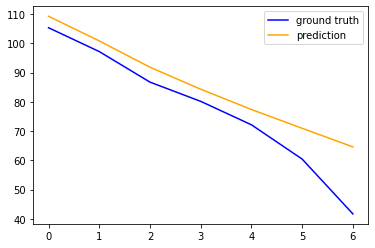

In [21]:
plt.plot(test, color = 'blue', label = "ground truth")
plt.plot(pred, color = 'orange', label = "prediction")
plt.legend()
plt.show()

In [22]:
# large training set and large lag
train, test = X[:-test_size], X[-test_size:]
model = AutoReg(train, lags = 100)
model = model.fit()
print('Coefficients: {}'.format(model.params))
pred = model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
rmse = np.sqrt(mean_squared_error(test, pred))
print("Test RMSE: {}".format(rmse))

Coefficients: [ 3.41170254  1.66981501 -0.51391872 -0.12444533  0.04464786 -0.30903279
  0.36366943 -0.39730112  0.80208311 -0.68829821 -0.09762451  0.35532855
 -0.06825912  0.10929781 -0.57281265  0.62422277 -0.18135558 -0.03787443
  0.11923485 -0.16927322 -0.02452547 -0.19869367  0.67130747 -0.32423554
 -0.179035    0.2236653  -0.13413753  0.04688044 -0.3374781   0.64513923
 -0.40198824  0.05225061  0.18218177 -0.32610786  0.2514639  -0.39012676
  0.63179782 -0.3221509  -0.06454113  0.10816427 -0.1140848   0.18810906
 -0.42696318  0.53697975 -0.21854993 -0.06831212  0.17526585 -0.16777871
  0.02322708 -0.27788896  0.53013034 -0.09665933 -0.1068014  -0.07831295
  0.00866099  0.0858156  -0.23657946  0.46450606 -0.27971733 -0.080344
  0.04125224  0.05146395  0.19236971 -0.46338258  0.4267745  -0.12463551
 -0.0560282   0.05626135 -0.05836195  0.03766612 -0.26696705  0.43716954
 -0.04091088 -0.20007367  0.01179629  0.05326995  0.01747273 -0.12657527
  0.25139001 -0.19329915 -0.01523031  0

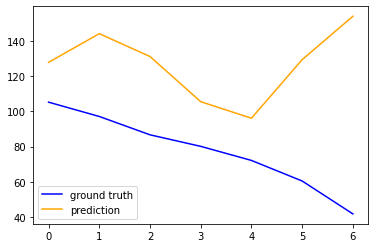

In [23]:
plt.plot(test, color = 'blue', label = "ground truth")
plt.plot(pred, color = 'orange', label = "prediction")
plt.legend()
plt.show()

We may use the latest tend of Time Series to estimate, manually, a proper range for lag to use.